# Assignment 1 _Fingerprint Recognition_

Implement two fingerprint recognition/verification systems.
One key-point based and one (local) image correlation based.

A high-level description will be provided with links to or hints of code snippets and libraries that you can reuse/adapt at your will (with proper referencing!).

In [1]:
import cv2
import numpy as np
import argparse
from matplotlib import pyplot as plt
from pathlib import Path
import fprmodules.enhancement as fe
from CMC import CMC
from sklearn.metrics import roc_curve

In [2]:
def read_DB(path):
    images = []
    labels = []
    imagePaths = sorted(Path(path).rglob("*.tif"))
    for imagePath in imagePaths:
        image = cv2.imread(path + imagePath.name)
        if (len(image.shape) > 2):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        images.append(image)
        label = imagePath.stem[1:3]
        labels.append(label)
    return (images, labels)

In [3]:
def enhance_images(images):
    for i in range(len(images)):
        try:
            img_e, mask, orientim, freqim = fe.image_enhance(images[i])
            img_e_u = cv2.normalize(img_e, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=0)
            images[i] = img_e_u
        except:
            print('error for: ', i)
    return images

In [4]:
def detect_orb(image):
    max_features = 400
    orb = cv2.ORB_create(max_features, scaleFactor=1.05, nlevels=32, edgeThreshold=35, patchSize=35)
    kp1, des1 = orb.detectAndCompute(image, None)
    return kp1, des1

In [5]:
def detect_SIFT(image):
    max_features = 600
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=max_features, nOctaveLayers=8, contrastThreshold=0.02,
                                       edgeThreshold=20, sigma=1.1)
    kp, des = sift.detectAndCompute(image, None)
    return kp, des

In [6]:
def detect_SURF(image):

    surf = cv2.xfeatures2d.SURF_create(hessianThreshold=150, nOctaves=4, nOctaveLayers=3)
    kp, des = surf.detectAndCompute(image, None)
    return kp, des

In [7]:
def detect_BRIEF(image):
    fast = cv2.FastFeatureDetector_create()
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    kp = fast.detect(image, None)
    kp, des = brief.compute(image, kp)
    return kp,des

In [8]:
def match_BruteForce(image1, image2, kp1, des1, kp2, des2):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches.sort(key=lambda x: x.distance, reverse=False)
    imMatches = cv2.drawMatches(image1, kp1, image2, kp2, matches[:10], None)  # , flags=2)

    # plt.imshow(imMatches), plt.show()
    GOOD_MATCH_PERCENT = 0.25
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    height, width = image2.shape[:2]
    im1Reg = cv2.warpPerspective(image1, M, (width, height))

    src_pts_tr = cv2.perspectiveTransform(src_pts, M, (1, 45))

#     plt.subplot(1, 2, 1)
#     plt.imshow(im1Reg, cmap='gray')
#     plt.subplot(1, 2, 2)
#     plt.imshow(image2, cmap='gray')
#     plt.show()
    return (matches, src_pts_tr, dst_pts)

In [9]:
def match_Flann_kdtree(image1, image2, kp1, des1, kp2, des2):
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)
    imMatches = cv2.drawMatches(image1, kp1, image2, kp2, good, None)  # , flags=2)

    #plt.imshow(imMatches), plt.show()


    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    try:
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

        height, width = image2.shape[:2]
        im1Reg = cv2.warpPerspective(image1, M, (width, height))
        
        src_pts_tr = cv2.perspectiveTransform(src_pts, M, (1, 45))
        

#         plt.subplot(1, 2, 1)
#         plt.imshow(im1Reg, cmap='gray')
#         plt.subplot(1, 2, 2)
#         plt.imshow(image2, cmap='gray')
#         plt.show()
    except:
        src_pts_tr = 0
        # print('E')
        pass
        
        
    return (matches, src_pts_tr, dst_pts)

In [10]:
def match_num_distance(src,dst,distance):
    num =0

    for i in range(len(src)):
        dist = np.linalg.norm(src[i][0]-dst[i][0])
        if dist <= distance:
            num +=1

    return num

In [11]:
def number_of_matches_Flann(matches, fl):
    num=0
    for m, n in matches:
        if m.distance < fl * n.distance:
            num += 1
    return num

In [12]:
def number_of_matches(matches, distance):
    num = 0
    for match in matches:
        if match.distance < distance:
            num += 1
    return num

In [13]:
images_db1, labels_db1 = read_DB('./fprdata/DB1_B/')

In [14]:
images_db1 = enhance_images(images_db1)

D:\KULeuven\Biometrics\Assignment1\AssignmentFPR1\fprmodules\enhancement\ridge_segment.py:106: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(wsqrmean - wmean*wmean)
D:\KULeuven\Biometrics\Assignment1\AssignmentFPR1\fprmodules\enhancement\ridge_segment.py:138: RuntimeWarning: invalid value encountered in greater
  mask = stddevim > thresh
c:\users\glavi\python37\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\glavi\python37\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\KULeuven\Biometrics\Assignment1\AssignmentFPR1\fprmodules\enhancement\ridge_filter.py:61: RuntimeWarning: invalid value encountered in greater
  ind = np.where(freq_1d>0);


error for:  3


In [15]:
images_db2, labels_db2 = read_DB('./fprdata/DB2_B/')
images_db3, labels_db3 = read_DB('./fprdata/DB3_B/')
images_db4, labels_db4 = read_DB('./fprdata/DB4_B/')

In [16]:
images_db2 = enhance_images(images_db2)
images_db3 = enhance_images(images_db3)
images_db4 = enhance_images(images_db4)

In [17]:
def get_scores(images, labels, descr, matching, d1, d2):
    same_matches = []
    diff_matches = []
    same_eucl = []
    diff_eucl = []

    y_true = []
    y_hat_features = []
    y_hat_distances = []
    for i in range(len(images)):
        for j in range(i+1, len(images)):
            if descr == 'ORB':
                kp1, des1 = detect_orb(images[i])
                kp2, des2 = detect_orb(images[j])
            elif descr == 'SIFT':
                kp1, des1 = detect_SIFT(images[i])
                kp2, des2 = detect_SIFT(images[j])
            elif descr == 'SURF':
                kp1, des1 = detect_SURF(images[i])
                kp2, des2 = detect_SURF(images[j])
            elif descr == 'BRIEF':
                kp1, des1 = detect_BRIEF(images[i])
                kp2, des2 = detect_BRIEF(images[j])
            
            if matching == 'BF':
                matches, src_pts_tr, dst_pts = match_BruteForce(images[i], images[j], kp1, des1, kp2, des2)
                match_num = number_of_matches(matches, d1)
            elif matching == 'Fkd':
                matches, src_pts_tr, dst_pts = match_Flann_kdtree(images[i], images[j], kp1, des1, kp2, des2)
                match_num = number_of_matches_Flann(matches, 0.7)
               
            try:
                num_dist = match_num_distance(src_pts_tr, dst_pts, d2)
            except:
                num_dist = 0
            
            y_hat_features.append(match_num)
            y_hat_distances.append(num_dist)

            if labels[i] ==labels[j]:
                y_true.append(1)
                same_matches.append(match_num)
                same_eucl.append(num_dist)

            else:
                y_true.append(0)
                diff_matches.append(match_num)
                diff_eucl.append(num_dist)
    return same_matches, diff_matches, same_eucl, diff_eucl, y_true, y_hat_features, y_hat_distances

In [18]:
MAX_FEATURES = 400
distance1 = 65
distance2 = 10

same_matches_db1_orb_bf, diff_matches_db1_orb_bf,\
same_eucl_db1_orb_bf, diff_eucl_db1_orb_bf, y_true_db1_orb_bf,\
y_hat_features_db1_orb_bf, y_hat_distances_db1_orb_bf = get_scores(images_db1, labels_db1, 'ORB', 'BF', distance1, distance2)


In [19]:
same_matches_db1_sift_fkd, diff_matches_db1_sift_fkd,\
same_eucl_db1_sift_fkd, diff_eucl_db1_sift_fkd, y_true_db1_sift_fkd,\
y_hat_features_db1_sift_fkd, y_hat_distances_db1_sift_fkd = get_scores(images_db1, labels_db1, 'SIFT', 'Fkd', distance1, distance2)

In [20]:
same_matches_db2_orb_bf, diff_matches_db2_orb_bf,\
same_eucl_db2_orb_bf, diff_eucl_db2_orb_bf, y_true_db2_orb_bf,\
y_hat_features_db2_orb_bf, y_hat_distances_db2_orb_bf = get_scores(images_db2, labels_db2, 'ORB', 'BF', distance1, distance2)

same_matches_db3_orb_bf, diff_matches_db3_orb_bf,\
same_eucl_db3_orb_bf, diff_eucl_db3_orb_bf, y_true_db3_orb_bf,\
y_hat_features_db3_orb_bf, y_hat_distances_db3_orb_bf = get_scores(images_db3, labels_db3, 'ORB', 'BF', distance1, distance2)

same_matches_db4_orb_bf, diff_matches_db4_orb_bf,\
same_eucl_db4_orb_bf, diff_eucl_db4_orb_bf, y_true_db4_orb_bf,\
y_hat_features_db4_orb_bf, y_hat_distances_db4_orb_bf = get_scores(images_db4, labels_db4, 'ORB', 'BF', distance1, distance2)

In [21]:
same_matches_db1_brief_bf, diff_matches_db1_brief_bf,\
same_eucl_db1_brief_bf, diff_eucl_db1_brief_bf, y_true_db1_sbrief_bf,\
y_hat_features_db1_brief_bf, y_hat_distances_db1_brief_bf = get_scores(images_db1, labels_db1, 'BRIEF', 'BF', 35, 10)

In [22]:
same_matches_db2_brief_bf, diff_matches_db2_brief_bf,\
same_eucl_db2_brief_bf, diff_eucl_db2_brief_bf, y_true_db2_sbrief_bf,\
y_hat_features_db2_brief_bf, y_hat_distances_db2_brief_bf = get_scores(images_db2, labels_db2, 'BRIEF', 'BF', 35, 10)

In [23]:
same_matches_db3_brief_bf, diff_matches_db3_brief_bf,\
same_eucl_db3_brief_bf, diff_eucl_db3_brief_bf, y_true_db3_sbrief_bf,\
y_hat_features_db3_brief_bf, y_hat_distances_db3_brief_bf = get_scores(images_db3, labels_db3, 'BRIEF', 'BF', 35, 10)

same_matches_db4_brief_bf, diff_matches_db4_brief_bf,\
same_eucl_db4_brief_bf, diff_eucl_db4_brief_bf, y_true_db4_sbrief_bf,\
y_hat_features_db4_brief_bf, y_hat_distances_db4_brief_bf = get_scores(images_db4, labels_db4, 'BRIEF', 'BF', 35, 10)

In [35]:
def show_hist_same_diff(same_matches, diff_matches, bin, title):
    plt.hist(same_matches, bins=bin, density=False, label='genuine')
    plt.hist(diff_matches,  bins=bin, density=False, alpha=0.5, label='impostor')
    plt.legend()
    plt.xlabel('match number')
    plt.ylabel('frequency')
    plt.title(title)
    plt.show()

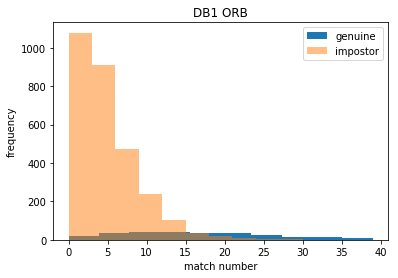

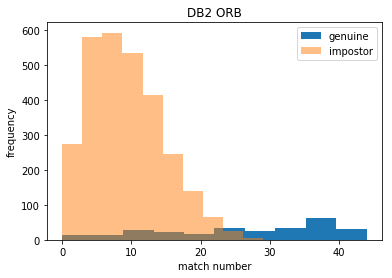

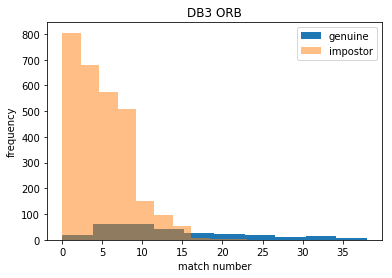

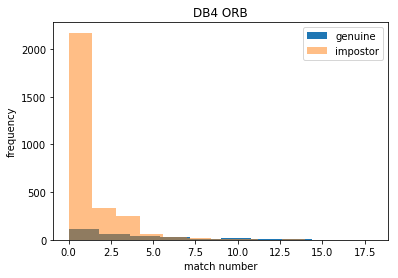

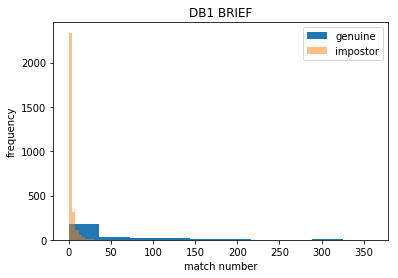

In [36]:
show_hist_same_diff(same_matches_db1_orb_bf,diff_matches_db1_orb_bf, 10 , 'DB1 ORB')
show_hist_same_diff(same_matches_db2_orb_bf,diff_matches_db2_orb_bf, 10, 'DB2 ORB' )
show_hist_same_diff(same_matches_db3_orb_bf,diff_matches_db3_orb_bf, 10 , 'DB3 ORB')
show_hist_same_diff(same_matches_db4_orb_bf,diff_matches_db4_orb_bf, 10 , 'DB4 ORB')
show_hist_same_diff(same_matches_db1_brief_bf,diff_matches_db1_brief_bf, 10, 'DB1 BRIEF' )

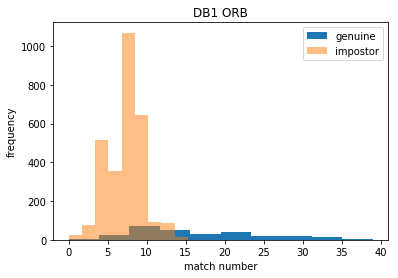

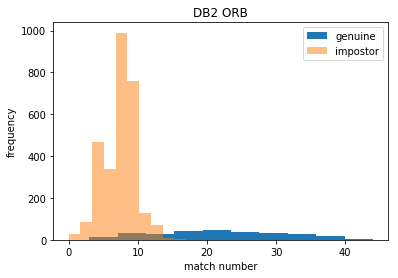

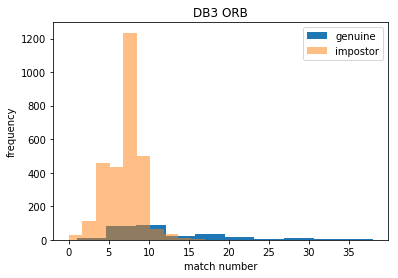

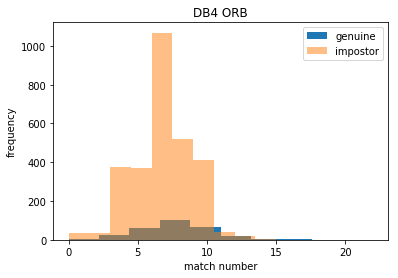

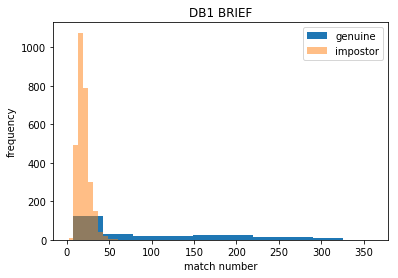

In [37]:
show_hist_same_diff(same_eucl_db1_orb_bf, diff_eucl_db1_orb_bf, 10, 'DB1 ORB' )
show_hist_same_diff(same_eucl_db2_orb_bf, diff_eucl_db2_orb_bf, 10, 'DB2 ORB' )
show_hist_same_diff(same_eucl_db3_orb_bf, diff_eucl_db3_orb_bf, 10, 'DB3 ORB' )
show_hist_same_diff(same_eucl_db4_orb_bf, diff_eucl_db4_orb_bf, 10, 'DB4 ORB' )
show_hist_same_diff(same_eucl_db1_brief_bf, diff_eucl_db1_brief_bf, 10 , 'DB1 BRIEF')

In [39]:
same_matches_db2_sift_fkd, diff_matches_db2_sift_fkd,\
same_eucl_db2_sift_fkd, diff_eucl_db2_sift_fkd, y_true_db2_sift_fkd,\
y_hat_features_db2_sift_fkd, y_hat_distances_db2_sift_fkd = get_scores(images_db2, labels_db2, 'SIFT', 'Fkd', distance1, distance2)

same_matches_db3_sift_fkd, diff_matches_db3_sift_fkd,\
same_eucl_db3_sift_fkd, diff_eucl_db3_sift_fkd, y_true_db3_sift_fkd,\
y_hat_features_db3_sift_fkd, y_hat_distances_db3_sift_fkd = get_scores(images_db3, labels_db3, 'SIFT', 'Fkd', distance1, distance2)

same_matches_db4_sift_fkd, diff_matches_db4_sift_fkd,\
same_eucl_db4_sift_fkd, diff_eucl_db4_sift_fkd, y_true_db4_sift_fkd,\
y_hat_features_db4_sift_fkd, y_hat_distances_db4_sift_fkd = get_scores(images_db4, labels_db4, 'SIFT', 'Fkd', distance1, distance2)

In [27]:
def plot_roc_curve(y_true, y_hat, color, label):
    lower, upper = min(y_hat), max(y_hat)
    y_hat_norm = [(x-lower)/(upper-lower) for x in y_hat]
    fpr_f, tpr_f, _ = roc_curve(y_true, y_hat)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_f, tpr_f, c=color, label=label)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    

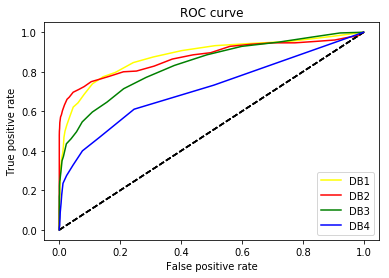

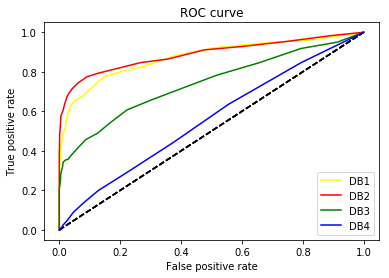

In [41]:
plot_roc_curve(y_true_db1_orb_bf, y_hat_features_db1_orb_bf, 'yellow',label='DB1')
plot_roc_curve(y_true_db2_orb_bf, y_hat_features_db2_orb_bf, 'red', label='DB2')
plot_roc_curve(y_true_db3_orb_bf, y_hat_features_db3_orb_bf, 'green', label='DB3')
plot_roc_curve(y_true_db4_orb_bf, y_hat_features_db4_orb_bf, 'blue', label='DB4')
plt.show()

plot_roc_curve(y_true_db1_sift_fkd, y_hat_features_db1_sift_fkd, 'yellow',label='DB1')
plot_roc_curve(y_true_db2_sift_fkd, y_hat_features_db2_sift_fkd, 'red', label='DB2')
plot_roc_curve(y_true_db3_sift_fkd, y_hat_features_db3_sift_fkd, 'green', label='DB3')
plot_roc_curve(y_true_db4_sift_fkd, y_hat_features_db4_sift_fkd, 'blue', label='DB4')
plt.show()

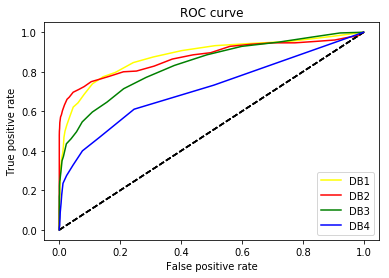

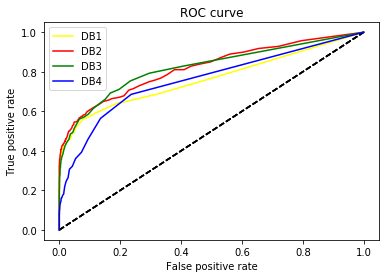

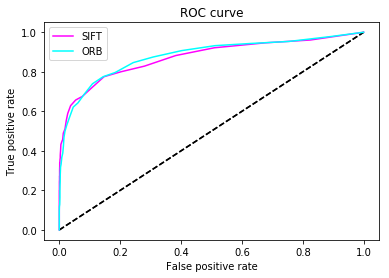

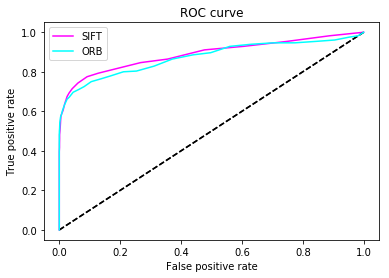

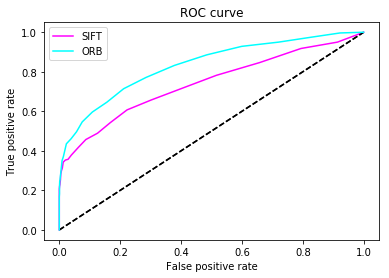

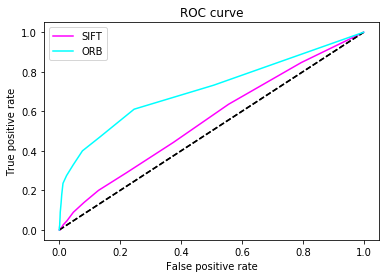

In [43]:
plot_roc_curve(y_true_db1_orb_bf, y_hat_features_db1_orb_bf, 'yellow',label='DB1')
plot_roc_curve(y_true_db2_orb_bf, y_hat_features_db2_orb_bf, 'red', label='DB2')
plot_roc_curve(y_true_db3_orb_bf, y_hat_features_db3_orb_bf, 'green', label='DB3')
plot_roc_curve(y_true_db4_orb_bf, y_hat_features_db4_orb_bf, 'blue', label='DB4')
plt.show()
plot_roc_curve(y_true_db1_sbrief_bf, y_hat_features_db1_brief_bf, 'yellow', label='DB1')
plot_roc_curve(y_true_db2_sbrief_bf, y_hat_features_db2_brief_bf, 'red', label='DB2')
plot_roc_curve(y_true_db3_sbrief_bf, y_hat_features_db3_brief_bf, 'green', label='DB3')
plot_roc_curve(y_true_db4_sbrief_bf, y_hat_features_db4_brief_bf, 'blue', label='DB4')
plt.show()

plot_roc_curve(y_true_db1_sift_fkd, y_hat_features_db1_sift_fkd, 'magenta',label='SIFT')
plot_roc_curve(y_true_db1_orb_bf, y_hat_features_db1_orb_bf, 'cyan', label='ORB')
plt.show()


plot_roc_curve(y_true_db2_sift_fkd, y_hat_features_db2_sift_fkd, 'magenta',label='SIFT')
plot_roc_curve(y_true_db2_orb_bf, y_hat_features_db2_orb_bf, 'cyan', label='ORB')
plt.show()


plot_roc_curve(y_true_db3_sift_fkd, y_hat_features_db3_sift_fkd, 'magenta',label='SIFT')
plot_roc_curve(y_true_db3_orb_bf, y_hat_features_db3_orb_bf, 'cyan', label='ORB')
plt.show()


plot_roc_curve(y_true_db4_sift_fkd, y_hat_features_db4_sift_fkd, 'magenta',label='SIFT')
plot_roc_curve(y_true_db4_orb_bf, y_hat_features_db4_orb_bf, 'cyan', label='ORB')
plt.show()

In [29]:
def get_ranks(images, labels, descr, matching, rank, dist):
    indexes = []
    for i in range(len(images)):
        true_label = labels[i]
        scores = []
        labels_ind = []
        if descr == 'ORB':
            kp1, des1 = detect_orb(images[i])
        elif descr == 'SIFT':
            kp1, des1 = detect_SIFT(images[i])
        elif descr == 'SURF':
            kp1, des1 = detect_SURF(images[i])
        elif desc == 'BRIEF':
            kp1, des1 = detect_BRIEF(images[i])
        for j in range(len(images)):
            if i != j:
                if descr == 'ORB':
                    kp2, des2 = detect_orb(images[j])
                elif descr == 'SIFT':
                    kp2, des2 = detect_SIFT(images[j])
                elif descr == 'SURF':
                    kp2, des2 = detect_SURF(images[j])
                elif desc == 'BRIEF':
                    kp2, des2 = detect_BRIEF(images[j])
                
                if matching == 'BF':
                    matches, src_pts_tr, dst_pts = match_BruteForce(images[i], images[j], kp1, des1, kp2, des2)
                    match_num = number_of_matches(matches, dist)
                elif matching == 'Fkd':
                    matches, src_pts_tr, dst_pts = match_Flann_kdtree(images[i], images[j], kp1, des1, kp2, des2)
                    match_num = number_of_matches_Flann(matches, dist)
                scores.append(match_num)
                labels_ind.append(labels[j])
        s = [x for _, x in reversed(sorted(zip(scores, labels_ind)))]
        index = s.index(true_label)
        indexes.append(index+1)
        
    ranks = []
    c = 0
    for i in range(1,rank+1):
        c += indexes.count(i)
        ranks.append(c/len(indexes))
    print(ranks)
    return ranks

In [30]:
ranks_db1_orb_bf = get_ranks(images_db1, labels_db1, 'ORB', 'BF', 20, 65)

[0.9, 0.925, 0.95, 0.95, 0.9625, 0.9625, 0.9625, 0.9625, 0.975, 0.975, 0.975, 0.975, 0.9875, 0.9875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [31]:
ranks_db2_orb_bf = get_ranks(images_db2, labels_db2, 'ORB', 'BF', 20, 65)
ranks_db3_orb_bf = get_ranks(images_db3, labels_db3, 'ORB', 'BF', 20, 65)
ranks_db4_orb_bf = get_ranks(images_db4, labels_db4, 'ORB', 'BF', 20, 65)

[0.9625, 0.9625, 0.9625, 0.9625, 0.975, 0.975, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.8875, 0.9375, 0.975, 0.9875, 0.9875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.6125, 0.7125, 0.825, 0.85, 0.8875, 0.925, 0.925, 0.9375, 0.95, 0.95, 0.9625, 0.9625, 0.975, 0.975, 0.975, 0.9875, 0.9875, 0.9875, 0.9875, 1.0]


In [32]:

ranks_db1_sift_fkd = get_ranks(images_db1, labels_db1, 'SIFT', 'Fkd', 20, 0.7)

[0.9, 0.925, 0.9625, 0.9625, 0.9625, 0.9625, 0.9625, 0.975, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875]


In [33]:
ranks_db2_sift_fkd = get_ranks(images_db2, labels_db2, 'SIFT', 'Fkd', 20, 0.7)
ranks_db3_sift_fkd = get_ranks(images_db3, labels_db3, 'SIFT', 'Fkd', 20, 0.7)
ranks_db4_sift_fkd = get_ranks(images_db4, labels_db4, 'SIFT', 'Fkd', 20, 0.7)

[0.9375, 0.9625, 0.9625, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.85, 0.8875, 0.9, 0.9125, 0.9375, 0.95, 0.95, 0.95, 0.9625, 0.9625, 0.9625, 0.9625, 0.9625, 0.9625, 0.9625, 0.9625, 0.9625, 0.9625, 0.9625, 0.9625]
[0.1625, 0.3125, 0.4375, 0.525, 0.65, 0.7, 0.7625, 0.7875, 0.8125, 0.8375, 0.85, 0.8875, 0.9125, 0.9375, 0.9375, 0.9375, 0.9625, 0.975, 0.975, 0.975]


In [34]:
ranks_db1_brief_bf = get_ranks(images_db1, labels_db1, 'ORB', 'BF', 20, 35)
ranks_db2_brief_bf = get_ranks(images_db2, labels_db2, 'ORB', 'BF', 20, 35)
ranks_db3_brief_bf = get_ranks(images_db3, labels_db3, 'ORB', 'BF', 20, 35)
ranks_db4_brief_bf = get_ranks(images_db4, labels_db4, 'ORB', 'BF', 20, 35)

[0.875, 0.8875, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925]
[0.975, 0.975, 0.975, 0.975, 0.975, 0.975, 0.975, 0.975, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 1.0, 1.0, 1.0]
[0.675, 0.7, 0.7125, 0.7125, 0.7125, 0.7125, 0.7125, 0.7125, 0.725, 0.7625, 0.7625, 0.7625, 0.7625, 0.7625, 0.7625, 0.7625, 0.8375, 0.8375, 0.8375, 0.8375]
[0.1875, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4]


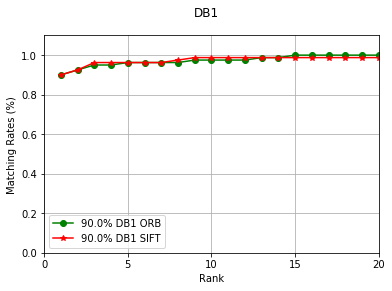

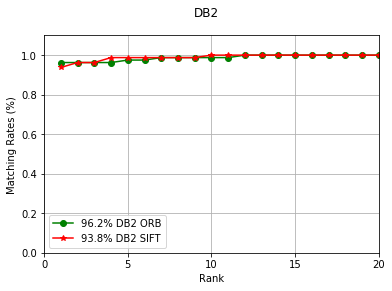

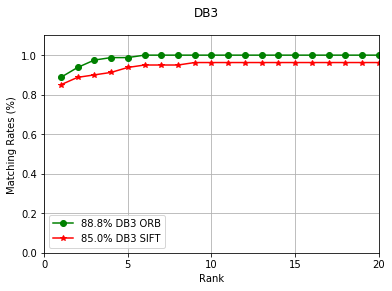

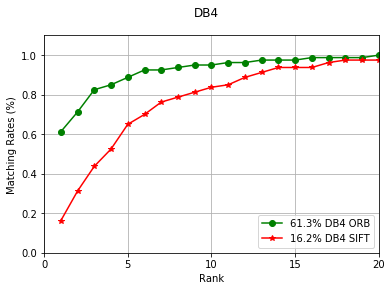

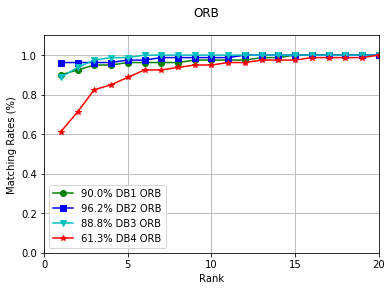

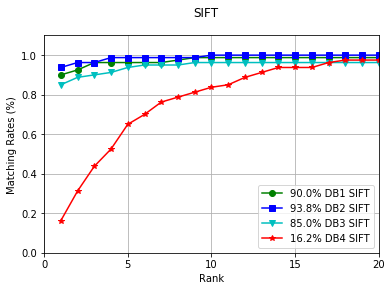

In [45]:
cmc_dict ={'DB1 ORB': ranks_db1_orb_bf,
          'DB1 SIFT': ranks_db1_sift_fkd}
cmc = CMC(cmc_dict)
cmc.plot(title='DB1')

cmc_dict ={'DB2 ORB': ranks_db2_orb_bf,
          'DB2 SIFT': ranks_db2_sift_fkd}
cmc = CMC(cmc_dict)
cmc.plot(title='DB2')

cmc_dict ={'DB3 ORB': ranks_db3_orb_bf,
          'DB3 SIFT': ranks_db3_sift_fkd}
cmc = CMC(cmc_dict)
cmc.plot(title='DB3')

cmc_dict ={'DB4 ORB': ranks_db4_orb_bf,
          'DB4 SIFT': ranks_db4_sift_fkd}
cmc = CMC(cmc_dict)
cmc.plot(title='DB4')

cmc_dict ={'DB1 ORB': ranks_db1_orb_bf,
          'DB2 ORB': ranks_db2_orb_bf,
          'DB3 ORB': ranks_db3_orb_bf,
          'DB4 ORB': ranks_db4_orb_bf}
cmc = CMC(cmc_dict)
cmc.plot(title='ORB')

cmc_dict ={'DB1 SIFT': ranks_db1_sift_fkd,
          'DB2 SIFT': ranks_db2_sift_fkd,
          'DB3 SIFT': ranks_db3_sift_fkd,
          'DB4 SIFT': ranks_db4_sift_fkd}
cmc = CMC(cmc_dict)
cmc.plot(title='SIFT')

